# Initialsising

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools as it

J = -1
B = 0
k = 1
mu0 = 0.5


# Lattice Class

In [27]:
class lattice:
    def __init__(self, ndims, length, temp, type): # If want non-square lattice, make length an array/tuple
        self.ndims = ndims
        self.length = length
        self.temp = temp
        # np.full creates an array of length ndims with values of length, to create the size tuple
        # Change to size=length for non-square lattice
        self.points = np.random.choice(a=[-1, 1], size=tuple(np.full(ndims, length, dtype=int)))
        self.mag = 0
        self.erg = 0
        self.type = str(type)
        self.update_M() # Change to product along entries of length for non-square lattice
        self.update_E()

    def get_neighbors(self, flip_index):
        neighbors = []
        # itertools.product creates the adjacent and diagonal neighbors of any ndarray point
        for rel_pos in it.product((-1, 0, 1), repeat=self.ndims): # Loop over all neighbors. 
            # Exclude the point itself and all diagonal neighbors
            if self.type == "adj":
                if not all(i == 0 for i in rel_pos) and not all(np.abs(i) == 1 for i in rel_pos): 
                    neighbors.append(self.points[tuple(i + i_rel for i, i_rel in zip(flip_index, rel_pos))]) # Add neighbor spin values
            if self.type == "diag":
                if not all(i == 0 for i in rel_pos) and all(np.abs(i) == 1 for i in rel_pos): 
                    neighbors.append(self.points[tuple(i + i_rel for i, i_rel in zip(flip_index, rel_pos))])
            if self.type == "both":
                neighbors.append(self.points[tuple(i + i_rel for i, i_rel in zip(flip_index, rel_pos))])
        neighbors = np.array(neighbors)
        return neighbors
    
    def local_E(self, flip_index):
        neighbors = self.get_neighbors(flip_index)
        local_E = J * np.sum(neighbors * self.points[flip_index]) - mu0 * B * self.points[flip_index]
        return local_E
    
    def update_E(self):
        energy = 0
        for index in it.product(range(-1,self.length-1), repeat=self.ndims): # If want non-square lattice, make product over different ranges()
            energy += self.local_E(index) - self.points[index]*mu0*B # Add to energy
        self.erg = energy / 2 # divide by 2 for double-counting
        
    def update_M(self): # Update magnetization
        self.mag = np.sum(self.points) / self.length**self.ndims

    def set_points(self, value): # Make spins uniform for testing
        self.points = np.random.choice(a=[value], size=tuple(np.full(self.ndims, self.length, dtype=int)))

# Simulator Algorithm Class

In [28]:
class ising_algos:
    def metropolis(self, lattice, n_steps):
    # P = min(1, e^(-del_E/kT))
    # Flip always accepted if energy decreases, flip accepted with probability if energy increases
        mag = []
        erg = []
        for ii in range(0,n_steps):
            rand_index = tuple(np.random.choice(a=range(-1,lattice.length-1), size=lattice.ndims))
            neighbors, del_E, success = self.flip(lattice, rand_index, "m")
            lattice.erg += del_E
            lattice.update_M()
            erg.append(lattice.erg)
            mag.append(lattice.mag)
        mag, erg = np.array(mag), np.array(erg)
        return np.array([erg, mag])
    
    
    def glauber(self, lattice, n_steps):
    # P = 1/(1+e^(del_E/kT))
    # Flips probabilistically based on energy difference
        mag = []
        erg = []
        for ii in range(0,n_steps):
            rand_index = tuple(np.random.choice(a=range(-1,lattice.length-1), size=lattice.ndims))
            neighbors, del_E, success = self.flip(lattice, rand_index, "g")
            lattice.erg += del_E
            lattice.update_M()
            erg.append(lattice.erg)
            mag.append(lattice.mag)
        mag, erg = np.array(mag), np.array(erg)
        return np.array([erg, mag])
            
    
    ## DOES NOT WORK YET
    def wolff(self, lattice, n_steps):
        mag = []
        erg = []
        for ii in range(0,n_steps):
            rand_index = tuple(np.random.choice(a=range(-1,lattice.length-1), size=lattice.ndims))
            self.flip_cluster(lattice, rand_index, "m")
            lattice.update_E()
            lattice.update_M()
            erg.append(lattice.erg)
            mag.append(lattice.mag)
        mag, erg = np.array(mag), np.array(erg)
        return np.array([erg, mag])
    
    def flip(self, lattice, flip_index, type):
        success = True
        init_E = lattice.local_E(flip_index)
        lattice.points[flip_index] = -1 * lattice.points[flip_index]
        fin_E = lattice.local_E(flip_index)
        del_E = fin_E - init_E
        if type == "m":
            if del_E >= 0 and np.random.rand() > np.exp(-1 * del_E/(k * lattice.temp)):
                lattice.points[flip_index] = -1 * lattice.points[flip_index]
                del_E = 0
                success = False
        if type == "g":
            if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):
                lattice.points[flip_index] = -1 * lattice.points[flip_index]
                del_E = 0
                success = False
    
        return [lattice.get_neighbors(flip_index), del_E, success]
    
    ## DOES NOT WORK YET
    def flip_cluster(self, lattice, flip_index):
        neighbors, del_E, success = self.flip(lattice, flip_index, "m")
        if success == True:
            for jj in neighbors:
                if lattice.points[neighbors[jj]] != lattice.points[flip_index]:
                    self.flip_cluster(lattice, neighbors[jj], "m")
        if success == False:
            for jj in neighbors:
                if lattice.points[neighbors[jj]] == lattice.points[flip_index]:
                    self.flip_cluster(lattice, neighbors[jj], "m")

# Visualization

In [29]:
def nBody_animation(num_lattices, mags, n_steps):
    # Given the array-like input variable t, initialize variables that store
    # the number of time steps and the length of each step.
    n_steps = len(n_steps)
    max_steps = int(max(n_steps))
    dt = round((max_steps/n_steps), 2)
    # Initialize array of Lattice position data - random for now
    # mags = np.random.randn(n_steps, num_lattices)    # Iterate through array mags to replace values in mags array with those in mags
    # for n in range(0,n_steps):
    #     for i in range(0,num_lattices):
    #         mags[n,i] = mags[n,i]
    # Create x, y, and z ranges based on the min, max values of x, y, and z
    # That appear in the mags array
    x_range = np.array([np.min(mags), np.max(mags)])
    y_range = np.array([0,0])
    z_range = np.array([0,0])
    # Initialize the figure
    layout = go.Layout(width=600, height=600, title="Magnetization Visualization")
    fig = go.Figure(layout=layout)
    # Assign unique random colors to each Lattice
    # And add the initial plot (time step zero)
    lat_colors = {}
    for i_lattice in range(num_lattices):
        rgb = np.random.randint(0, 255, 3)
        color = f'rgb({rgb[0]},{rgb[1]},{rgb[2]})'
        lat_colors[i_lattice] = color
        # Add initial scatter plot (marker)
        fig.add_trace(go.Scatter3d(
            x=[], y=[], z=[],
            mode='markers',
            marker=dict(size=5, color=color),
            name=f'Lattice {i_lattice}'
        ))
        # Add magsectory line
        fig.add_trace(go.Scatter3d(
            x=[], y=[], z=[],
            mode='lines',
            line=dict(color=color, width=2),
            name=f'magsectory {i_lattice}'
        ))
    # Assign length of magsectory tail
    tail_length = 1000
    # Create frames for each time step
    frames = []
    for k in range(n_steps):
        frame_data = []
        for i_lattice in range(num_lattices):
            # Current mags of Lattices (scatter plot)
            frame_data.append(go.Scatter3d(
                x=np.array(mags[k, i_lattice]),
                y=np.zeros(max_steps),
                z=np.zeros(max_steps),
                mode='markers',
                marker=dict(size=5, color=lat_colors[i_lattice]),
                name=f'Lattice {i_lattice + 1}'
            ))
            # Lattice magsectory tails (lines)
            start_index = max(0, k - tail_length + 1)  # Ensure we don’t try to make a magsectory start before 0
            frame_data.append(go.Scatter3d(
                x=mags[start_index:k+1, i_lattice],
                y=np.zeros(max_steps),
                z=np.zeros(max_steps),
                mode='lines',
                line=dict(color=lat_colors[i_lattice], width=2),
                name=f'magsectory {i_lattice + 1}'
            ))
        frames.append(go.Frame(data=frame_data, name=f'frame{k}'))
    fig.frames = frames
    # Add animation controls
    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[None, {"frame": {"duration": 50, "redraw": True},
                                  "fromcurrent": True, "transition": {"duration": 0}}]),
                dict(label="Pause",
                     method="animate",
                     args=[[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}])
            ],
            direction="left",
            pad={"r": 10, "t": 87},
            showactive=False,
            x=0.1, xanchor="right", y=0, yanchor="top"
        )],
        sliders=[dict(
            active=0,
            yanchor="top", xanchor="left",
            currentvalue={"prefix": "Time: ", "suffix": " s"},
            pad={"b": 10, "t": 50}, len=0.9, x=0.1, y=0,
            steps=[{"method": "animate",
                    "args": [[f'frame{k}'],
                             {"frame": {"duration": 10, "redraw": True},
                              "mode": "immediate",
                              "transition": {"duration": 0}}], "label": f"{k * dt:.2f}"}
                   for k in range(n_steps)]
        )]
    )
    # Update initial layout to include the custom axis ranges set above
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='x (m)', range=[x_range[0], x_range[1]], autorange=False),
            yaxis=dict(title='y (m)', range=[y_range[0], y_range[1]], autorange=False),
            zaxis=dict(title='z (m)', range=[z_range[0], z_range[1]], autorange=False),
            aspectratio=dict(x=1, y=1, z=1)
        )
    )
    return fig

In [30]:
L1 = lattice(2,25,273)
# print(L1.points)
# print(L1.erg)
# print(L1.mag)

TypeError: lattice.__init__() missing 1 required positional argument: 'type'

In [31]:
L1 = lattice(2,3,0) 
# Code faulty for matrix with length==2, neighbor indices quadruple count rather than double count. 
# Is a problem when matrix values are uniform
L1.set_points(-1)
# print(L1.points)
# print(L1.erg)
# print(L1.mag)


TypeError: lattice.__init__() missing 1 required positional argument: 'type'

# Metropolis Implementation

Text(0, 0.5, 'Magnetization (something)')

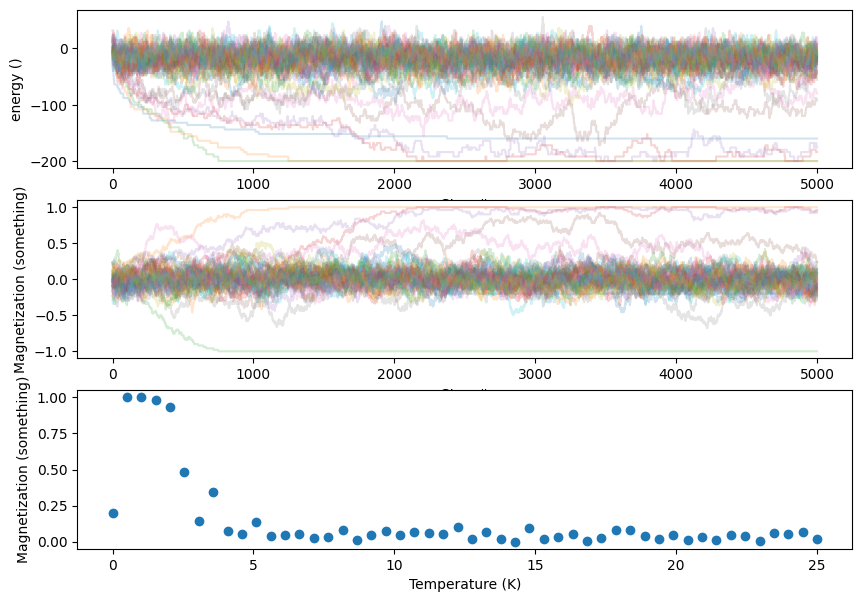

In [32]:
# Metropolis plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "adj")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.metropolis(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


# Glauber Implementation

/tmp/ipykernel_1491/611691896.py:58: RuntimeWarning: overflow encountered in exp
  if np.random.rand() >= (1 / (1 + np.exp(del_E / (k*lattice.temp)))):


Text(0, 0.5, 'Magnetization (something)')

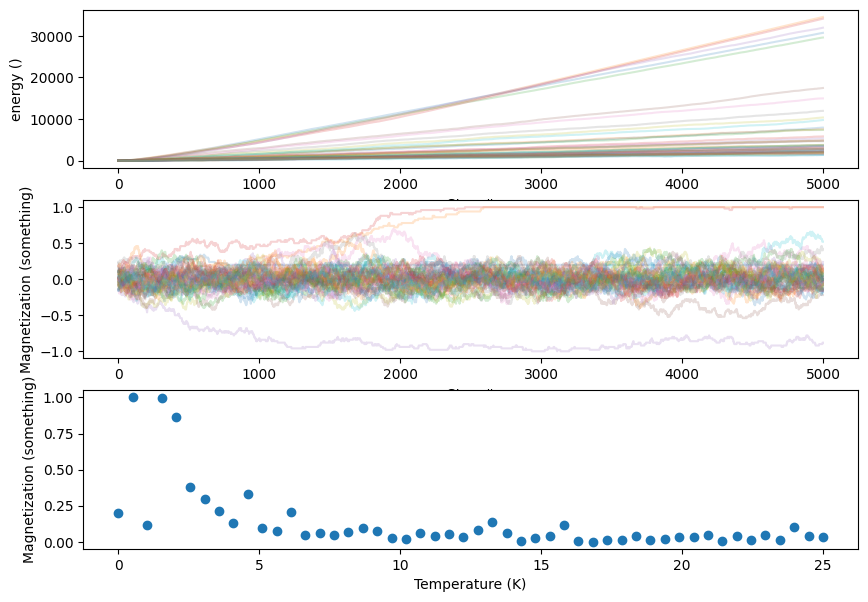

In [ ]:
# Glauber plots
temps = np.linspace(1/1e10,25,50)
mags = np.zeros(len(temps))
algo = ising_algos()
lattices = []
for ii in range(0,len(temps)):
    L = lattice(2,10,temps[ii], "adj")
    lattices.append(L)

n_steps = 5000
steps = range(0,n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)
for ii in range(0,len(lattices)):
    erg, mag = algo.glauber(lattices[ii], n_steps)
    mags[ii] = np.abs(np.average(mag[4000:]))
    ax = axes[0]
    ax.plot(steps,erg,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("energy ()")
    ax = axes[1]
    ax.plot(steps,mag,alpha=0.2)
    ax.set_xlabel("Step #")
    ax.set_ylabel("Magnetization (something)")

ax = axes[2]
ax.scatter(temps, mags)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Magnetization (something)")


# Wolff Implementation